# Define Function

## Noisy Label

In [1]:
from numpy.testing import assert_array_almost_equal
import numpy as np
def multiclass_noisify(y, P, random_state=0):
    """ Flip classes according to transition probability matrix T.
    It expects a number between 0 and the number of classes - 1.
    where y is array of label of dataset that is one-hot labeled
    P is probability table that size = (num_classes, num_classes)
    """
    ## check size of label and prob matrix
    # print (np.max(y), P.shape[0])
    assert P.shape[0] == P.shape[1]
    assert np.max(y) < P.shape[0]

    # row stochastic matrix
    assert_array_almost_equal(P.sum(axis=1), np.ones(P.shape[1]))
    assert (P >= 0.0).all()

    ## create new label
    m = y.shape[0]
    # print (m)
    new_y = y.copy()
    ## create Randomstate object
    flipper = np.random.RandomState(random_state)

    for idx in np.arange(m):
        i = np.argmax(y[idx])
        # num_label = np.count_nonzero(y[idx])

        # draw a vector with only an 1
        flipped = flipper.multinomial(1, P[i, :], 1)[0]

        # swap 
        if np.max(y[idx]) !=0:
            # print(np.where(flipped == 1)[0][0])
            new_y[idx][i] = 0
            new_y[idx][np.where(flipped == 1)[0][0]] = 1
        else:
            if np.where(flipped == 1)[0]!= i:
                new_y[idx][np.where(flipped == 1)[0][0]] = 1
        # new_y[idx] = flipped


    return new_y

def noisify_pairflip(y_train, noise, random_state=None, nb_classes=10):
    """mistakes:
        flip in the pair

        y_train is one-hot label of dataset
        noise is noise rate for creating noisy label
        random_state is seed for creating noisy label
        nb_classes is number of classes of dataset
    """
    P = np.eye(nb_classes)
    ## noise rate
    n = noise

    if n > 0.0:
        # 0 -> 1
        P[0, 0], P[0, 1] = 1. - n, n
        for i in range(1, nb_classes-1):
            P[i, i], P[i, i + 1] = 1. - n, n
        P[nb_classes-1, nb_classes-1], P[nb_classes-1, 0] = 1. - n, n

        y_train_noisy = multiclass_noisify(y_train, P=P,
                                           random_state=random_state)
        actual_noise = np.average(y_train_noisy == y_train,axis=1)
        actual_noise = (actual_noise!=1).mean()
        assert actual_noise > 0.0
        print('Actual noise %.2f' % actual_noise)
        y_train = y_train_noisy
    # print (P)

    return y_train,actual_noise

def noisify_multiclass_symmetric(y_train, noise, random_state=None, nb_classes=10):
    """mistakes:
        flip in the symmetric way
        y_train is one-hot label of dataset
        noise is noise rate for creating noisy label
        random_state is seed for creating noisy label
        nb_classes is number of classes of dataset
    """
    P = np.ones((nb_classes, nb_classes))
    n = noise
    P = (n / (nb_classes - 1)) * P

    if n > 0.0:
        # 0 -> 1
        P[0, 0] = 1. - n
        for i in range(1, nb_classes-1):
            P[i, i] = 1. - n
        P[nb_classes-1, nb_classes-1] = 1. - n

        y_train_noisy = multiclass_noisify(y_train, P=P,
                                           random_state=random_state)
        actual_noise = np.average(y_train_noisy == y_train,axis=1)
        actual_noise = (actual_noise!=1).mean()
        assert actual_noise > 0.0
        print('Actual noise %.2f' % actual_noise)
        y_train = y_train_noisy
    # print(P)

    return y_train, actual_noise

## Load & Create Dataset

### Cifar10

In [2]:
from tensorflow.keras import datasets
import tensorflow as tf
from tensorflow.keras import layers
def LoadDataset_Cifar10(batch_size=32,noise_rate = 0.2,randomType='uniform', randomState=7,filter_mask = None):
    """Use for loading CIFAR10 dataset, creating noisy label in dataset and generating tf.keras.Dataset by given batch_size
        randomType mean type of noisy label, 'uniform' and 'pairflip'
        filter_mask use in stage3 when you want to cleanse noisy label by filter_mask from stage2
    """
    (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

    input_shape = train_images.shape[1:]
    classes = 10
    num_samples = train_images.shape[0]

    train_labels  = tf.keras.utils.to_categorical(train_labels, num_classes = classes)
    test_labels  = tf.keras.utils.to_categorical(test_labels, num_classes = classes)

    if randomType == 'uniform':
        new_label_train_sym,actual_noise_rate = noisify_multiclass_symmetric(train_labels, noise_rate, random_state=randomState, nb_classes=classes)
    elif randomType == 'pairflip':
        new_label_train_sym,actual_noise_rate = noisify_pairflip(train_labels, noise_rate, random_state=randomState, nb_classes=classes)

    noise_or_not = np.sum(new_label_train_sym != train_labels,axis=1)
    noise_or_not = noise_or_not.astype(bool)
    noise_or_not = ~noise_or_not

    data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomCrop(input_shape[0],input_shape[1])

    ]
    )

    if filter_mask:
        filter_mask = filter_mask.astype(bool)
        train_images = train_images[filter_mask]
        new_label_train_sym = new_label_train_sym[filter_mask]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, new_label_train_sym))
    train_dataset = train_dataset.batch(batch_size).map(lambda x, y: (data_augmentation(x), y))

    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    test_dataset = test_dataset.batch(batch_size)

    return train_dataset,test_dataset,train_images.shape,classes,noise_or_not

### NIH CXR

In [3]:
import pandas as pd
import os
import json
import fnmatch
def create_nih_label(path):
    """function for creating one-hot label of NIH_CXR dataset from given file and save it as csv file
        this function run once when first time of loading NIH_CXR dataset
    """
    nih_label_csv = pd.read_csv(path+"Data_Entry_2017.csv")
    nih_label = pd.DataFrame()
    nih_label['Image Index'] = nih_label_csv['Image Index']
    nih_label['Finding Labels'] = nih_label_csv['Finding Labels']
    nih_label['one_hot'] = None

    nih_class = ["Atelectasis", "Cardiomegaly","Effusion","Infiltration","Mass","Nodule","Pneumonia","Pneumothorax","Consolidation","Edema","Emphysema","Fibrosis","Pleural_Thickening","Hernia"]
    zero_onehot = [0 for j in range(len(nih_class))]
    for idx,i in enumerate(nih_label['Finding Labels']):
        onehot = zero_onehot.copy()
        if i == 'No Finding':
            nih_label['one_hot'].iloc[idx] = zero_onehot
        else:
            list_l = i.split('|')
            for j in list_l:
                onehot[nih_class.index(j)] = 1
            nih_label['one_hot'].iloc[idx] = onehot
    nih_label.to_csv("./nih_label.csv")
    

def LoadDataset_NIH_CXR(nih_dataset_path = "D:/Work_archived/WIL-Onboard/NIH_dataset/",batch_size=32,img_height=256,img_width=256,noise_rate = 0.2,randomType='uniform', randomState=7,filter_mask = None):
    """Use for loading NIH_CXR dataset, creating noisy label in dataset and generating tf.keras.Dataset by given batch_size
        randomType mean type of noisy label, 'uniform' and 'pairflip'
        nih_dataset_path is directory of NIH_dataset
        img_height, img_width is size of image when use to train model
    """
    if not os.path.exists("./nih_label.csv"):
        create_nih_label(nih_dataset_path)
    nih_label = pd.read_csv("./nih_label.csv")
    data_label = []
    for i in nih_label['one_hot']:
        data_label.append(json.loads(i))
    data_label = np.array(data_label)
    data_label = data_label.astype(float)
    list_image_dir=[]
    for path in os.scandir(nih_dataset_path):
        if path.is_dir():
            list_image_dir.append(path.name)
    for i,j in enumerate(list_image_dir):
        list_image_dir[i] = nih_dataset_path + "/" + j
    
    classes = len(data_label[0])

    if randomType == 'uniform':
        noise_data_label,actual_noise_rate = noisify_multiclass_symmetric(data_label[:94999], noise_rate, random_state=randomState, nb_classes=classes)
    elif randomType == 'pairflip':
        noise_data_label,actual_noise_rate = noisify_pairflip(data_label[:94999], noise_rate, random_state=randomState, nb_classes=classes)

    noise_or_not = np.sum(noise_data_label != data_label[:94999],axis=1)
    noise_or_not = noise_or_not.astype(bool)
    noise_or_not = ~noise_or_not

    batch_size = 64
    img_h = img_height
    img_w = img_width
    random_seed = 7
    dataset_nih_list = []
    start_idx = 0
    end_idx = 0
    data_label[:94999] = noise_data_label
    data_label = data_label.tolist()
    for idx, dir in enumerate(list_image_dir):
        count = len(fnmatch.filter(os.listdir(dir+"/images"), '*.png'))
        end_idx = start_idx + count
        dataset_nih_list.append(tf.keras.utils.image_dataset_from_directory(directory=dir,
                                                    labels = data_label[start_idx:end_idx],
                                                    label_mode = 'int',
                                                    color_mode = 'grayscale',
                                                    batch_size = batch_size,
                                                    image_size = (img_h,img_w),
                                                    seed = random_seed
                                                    ))
        start_idx += count
    input_shape = (94999, img_h,img_w,1)
    train_dataset = dataset_nih_list[0]
    for i in range(1,len(dataset_nih_list)-2):
        train_dataset = train_dataset.concatenate(dataset_nih_list[i])
    test_dataset = dataset_nih_list[len(dataset_nih_list)-2].concatenate(dataset_nih_list[len(dataset_nih_list)-1])

    return train_dataset, test_dataset, input_shape, classes, noise_or_not


## Model

In [4]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Rescaling, Input
def build_resnet_model(input_shape=(256,256,1),classes=14,type='multi_label'):
    """use for building ResNet101 architecture which has Rescaling layer after input layer and change output layer by type of prediction
        type mean type of label, 'multi_label' or 'multi_class'
    """
    
    if type == 'multi_label':
        out_activation = 'sigmoid'
    else:
        out_activation = 'softmax'

    resnet = ResNet101(include_top=False,weights=None,input_shape=input_shape,classes=classes,pooling='avg')

    out = tf.keras.layers.Dense(classes,activation=out_activation)(resnet.output)
    res_model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

    inp = Input(input_shape)
    scaled_inp = Rescaling(1./255)(inp)
    otp = res_model(scaled_inp)

    model = tf.keras.models.Model(inputs= inp, outputs=otp)
    model.summary()
    res_model.summary()
    
    return model

## Other function

In [5]:
import json
def save_json(var,path):
    """Use for saving list to json file
    """
    jsonStr = json.dumps(var)
    jsonFile = open(path +".json", "w")
    jsonFile.write(jsonStr)
    jsonFile.close()

def load_json(path):
    """Use for laoding json file to list
    """
    fileObject = open(path +".json", "r")
    jsonContent = fileObject.read()
    var = json.loads(jsonContent)
    return var

In [6]:
def average_top_loss(loss_array):
    """Use for averaging loss array into 5 ranks 0-20%, 20-40%, 40-60%, 60-100%
    """
    # ind_1_sorted = np.argsort(loss_array)
    # loss = loss_array[ind_1_sorted].copy()
    loss = loss_array[::-1]
    top_0_20 = np.array(loss[:(len(loss)*20)//100])
    # top_10_20 = np.array(loss[(len(loss)*10)//100:(len(loss)*20)//100])
    top_20_40 = np.array(loss[(len(loss)*20)//100:(len(loss)*40)//100])
    top_40_60 = np.array(loss[(len(loss)*40)//100:(len(loss)*60)//100])
    top_60_100 = np.array(loss[(len(loss)*60)//100:])
    # return [top_0_20.mean(),top_10_20.mean(),top_20_40.mean(),top_40_60.mean(),top_60_100.mean()]
    return [top_0_20.mean(),top_20_40.mean(),top_40_60.mean(),top_60_100.mean()]

In [36]:
import matplotlib.pyplot as plt
def plot_loss_graph(loss,sorted_ind,r1=0.01,r2=0.001,c=10):
    """Use for ploting graph of loss in 5 rank with x axis is epoch and y axis is loss value
    """
    ranked_loss = []
    for i in loss:
        ranked_loss.append(i[sorted_ind].tolist().copy())
    top_ranked_loss = []
    for i in ranked_loss:
        top_ranked_loss.append(average_top_loss(i).copy())

    all_loss = top_ranked_loss

    x = [[].copy() for i in range(len(all_loss[0]))]
    x_lr = []
    y = range(1,1+len(all_loss))
    fig, ax = plt.subplots(2,1)
    for j in range(len(all_loss)):
        t = (j % c) / float((c)-1)
        lr = (1 - t) * r1 + t * r2
        x_lr.append(lr)
        for i in range(len(all_loss[0])):
            x[i].append(float(all_loss[j][i]))

    text_label = ["top0-20%","top20-40%", "top40-60%", "top60_100%"]

    ax[0].plot(y,x_lr,label= "lr")
    for i in range(len(all_loss[0])):
        ax[1].plot(y,x[i],label = text_label[i])
    
    fig.set_figheight(10)
    fig.set_figwidth(15)
    ax[0].set_ylabel('Learning Rate')
    ax[1].set_ylabel('Training Loss')
    # ax[1].set_ylim(0,4)
    ax[1].set_xlabel('Epoch')
    fig.suptitle('Loss Average in Training Loop')
    ax[1].legend()
    fig.align_labels()
    plt.show()


In [8]:
def noise_accuracy(sorted_ind,noise_or_not, forget_rate):
    samples_size = len(sorted_ind)
    cut_off_size = int(samples_size*(1-forget_rate))
    noise_accuracy = 1-(np.sum(noise_or_not[sorted_ind[cut_off_size:]]) /len(noise_or_not[sorted_ind[cut_off_size:]]))
    print('noise_accuracy at top',forget_rate , 'is ', noise_accuracy)
    return noise_accuracy


## Training Loop

In [9]:
from tensorflow import keras

def first_stage(model,train_dataset,val_dataset,num_samples,type='multi_label',max_epoch=5,load_weight = False,savepath = './save/f1_checkpoint',loadpath = './save/f1_checkpoint'):
    """Stage1 and Stage3 Training Loop
        In this loop, it just like normal model training loop with constant learning
        output is loss of all samples in each epoch for seeing loss behavior
    """
    savepath = savepath

    all_sample_loss = []

    if load_weight:
        model.load_weights(loadpath)

    optimizer = keras.optimizers.SGD(
                    learning_rate=0.01,
                    momentum=0.9,
                    decay = 5e-4
                )
    if type == 'multi_label':
        loss_fn = keras.losses.BinaryCrossentropy(reduction="auto")
        loss_fn_none = keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        model.compile(optimizer=optimizer, loss=loss_fn,metrics=['binary_accuracy'])
    else:
        loss_fn = keras.losses.CategoricalCrossentropy(reduction="auto")
        loss_fn_none = keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        model.compile(optimizer=optimizer, loss=loss_fn,metrics=['categorical_accuracy'])


    model.compile(optimizer=optimizer, loss=loss_fn,metrics=['categorical_accuracy'])

    example_loss = np.zeros(num_samples)

    for epoch in range(max_epoch):
        
        indexes =0

        print("epoch : ", epoch)
        
        model.fit(x=train_dataset,epochs=1,verbose=1,validation_data=val_dataset)
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            y_pred = model.predict(x_batch_train)
            batch_loss = loss_fn_none(y_batch_train,y_pred)
            for i in batch_loss.numpy():
                example_loss[indexes]=i
                indexes +=1

        all_sample_loss.append(example_loss.tolist().copy())
        save_json(example_loss.tolist().copy(),'./save_loss/loss_f1_'+str(epoch))

        model.save_weights(savepath)

    return all_sample_loss


In [10]:
def second_stage(model,train_dataset,val_dataset,num_samples,noise_or_not=None,type='multi_label',max_epoch=5,r1=0.01,r2=0.001,cy_loop = 10,forget_rate=0.1):
    """Stage2 Training Loop (main O2U_net)
        In this loop, it will train model with cyclical learning rate in linear form where r1 is maximum lr, r2 is minimum lr, cy_loop is number of epoch for calculating r1 to r2
        forget_rate is rank of cut off noise use in creating filter_mask
        noise_or_not is ground truth which is boolean of each samples which True mean it is true label and False mean it is noisy label
    """
    savepath = './save/s2_checkpoint'

    all_sample_loss = []
    # all_sample_loss_avg = []

    optimizer = keras.optimizers.SGD(
                    learning_rate=0.01,
                    momentum=0.9,
                    decay = 5e-4
                )
    if type == 'multi_label':
        loss_fn = keras.losses.BinaryCrossentropy(reduction="auto")
        loss_fn_none = keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        model.compile(optimizer=optimizer, loss=loss_fn,metrics=['binary_accuracy'])
    else:
        loss_fn = keras.losses.CategoricalCrossentropy(reduction="auto")
        loss_fn_none = keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        model.compile(optimizer=optimizer, loss=loss_fn,metrics=['categorical_accuracy'])

    # model.fit(x=train_dataset,epochs=epochs,verbose=1, callbacks=[history],
    #                     validation_data=val_dataset)
    # for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    #     y_pred = model.predict(x_batch_train)
    #     all_sample_loss.append(loss_fn(y_batch_train,y_pred))

    moving_loss_dic = np.zeros(num_samples)
    globals_loss = 0
    example_loss = np.zeros(num_samples)

    for epoch in range(max_epoch):
        
        indexes =0
        t = (epoch % cy_loop) / float((cy_loop)-1)
        lr = (1 - t) * r1 + t * r2

        model.optimizer.learning_rate = lr 
        print("epoch : ", epoch, "lr:%f" % lr)
        
        model.fit(x=train_dataset,epochs=1,verbose=1,validation_data=val_dataset)
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            y_pred = model.predict(x_batch_train)
            batch_loss = loss_fn_none(y_batch_train,y_pred)
            for i in batch_loss.numpy():
                example_loss[indexes]=i
                indexes +=1

        
        all_sample_loss.append(example_loss.tolist().copy())
        save_json(example_loss.tolist().copy(),'./save_loss/loss_s2_'+str(epoch))

        example_loss = example_loss - example_loss.mean()
        # all_sample_loss_avg.append(average_top_loss(example_loss).copy())
        moving_loss_dic=moving_loss_dic+example_loss

        ## return indices of sorted array
        ind_1_sorted = np.argsort(moving_loss_dic)
		## sort total by use sorted indices array
        loss_1_sorted = moving_loss_dic[ind_1_sorted]

		## set nth rank to keep
        remember_rate = 1 - forget_rate
        num_remember = int(remember_rate * len(loss_1_sorted))
        if noise_or_not is not None:
            ## find accuracy of noise detection
            noise_accuracy=np.sum(noise_or_not[ind_1_sorted[num_remember:]]) / float(len(loss_1_sorted)-num_remember)

            ## create filter_mask
            mask = np.ones_like(example_loss,dtype=np.float32)
            ## set top n% rank to zero (for cleansing noise)
            mask[ind_1_sorted[num_remember:]]=0

            ## find top 0.1 noise accuracy
            top_accuracy_rm=int(0.9 * len(loss_1_sorted))
            top_accuracy= 1-np.sum(noise_or_not[ind_1_sorted[top_accuracy_rm:]]) / float(len(loss_1_sorted) - top_accuracy_rm)
            print ( "noise_accuracy:%f"%(1-noise_accuracy),"top 0.1 noise accuracy:%f"%top_accuracy)


        
    return all_sample_loss,mask,ind_1_sorted


# Main

Run all cell above to define all function

In [11]:
train_dataset,test_dataset,dataset_shape,num_class,noise_or_not = LoadDataset_Cifar10(batch_size=256,noise_rate = 0.2,randomType='uniform', randomState=7)

Actual noise 0.20


In [12]:
# train_dataset,test_dataset,dataset_shape,num_class,noise_or_not = LoadDataset_NIH_CXR(nih_dataset_path = "D:/Work_archived/WIL-Onboard/NIH_dataset/",batch_size=32,img_height=64,img_width=64,noise_rate = 0.2,randomType='uniform', randomState=7)

Actual noise 0.20
Found 4999 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 7121 files belonging to 1 classes.


In [26]:
# model = build_resnet_model(input_shape=dataset_shape[1:],classes=num_class,type='multi_label')
model = build_resnet_model(input_shape=dataset_shape[1:],classes=num_class,type='multi_class')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
model (Functional)           (None, 10)                42678666  
Total params: 42,678,666
Trainable params: 42,573,322
Non-trainable params: 105,344
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
___________________________________________________________

In [27]:
# loss_stage2, filter_mask,sorted_ind = second_stage(model,train_dataset,test_dataset,num_samples=dataset_shape[0],noise_or_not=noise_or_not,type='multi_label',max_epoch=50,r1=0.01,r2=0.001,cy_loop=10)
loss_stage2, filter_mask,sorted_ind = second_stage(model,train_dataset,test_dataset,num_samples=dataset_shape[0],noise_or_not=noise_or_not,type='multi_class',max_epoch=50,r1=0.01,r2=0.001,cy_loop=10)

epoch :  0 lr:0.010000
196/196 [==============================] - 60s 210ms/step - loss: 3.2851 - categorical_accuracy: 0.1492 - val_loss: 26.1265 - val_categorical_accuracy: 0.1136
noise_accuracy:0.226000 top 0.1 noise accuracy:0.226000
epoch :  1 lr:0.009000
196/196 [==============================] - 38s 193ms/step - loss: 2.4244 - categorical_accuracy: 0.2639 - val_loss: 2.0479 - val_categorical_accuracy: 0.2852
noise_accuracy:0.397600 top 0.1 noise accuracy:0.397600
epoch :  2 lr:0.008000
196/196 [==============================] - 38s 194ms/step - loss: 2.2145 - categorical_accuracy: 0.3141 - val_loss: 2.0243 - val_categorical_accuracy: 0.3847
noise_accuracy:0.446800 top 0.1 noise accuracy:0.446800
epoch :  3 lr:0.007000
196/196 [==============================] - 35s 177ms/step - loss: 2.1666 - categorical_accuracy: 0.3342 - val_loss: 2.1045 - val_categorical_accuracy: 0.3467
noise_accuracy:0.451400 top 0.1 noise accuracy:0.451400
epoch :  4 lr:0.006000
196/196 [===================

In [29]:
save_json(loss_stage2,"./save_loss/loss_s2_data_13")
save_json(filter_mask.tolist(),"./save_mask/mask_13")
save_json(sorted_ind.tolist(),"./save_ranked_list/ranked_ind_13")

In [30]:
loss_stage2 = np.array(load_json('./save_loss/loss_s2_data_13'))
filter_mask = np.array(load_json("./save_mask/mask_13"))
sorted_ind =  np.array(load_json("./save_ranked_list/ranked_ind_13"))

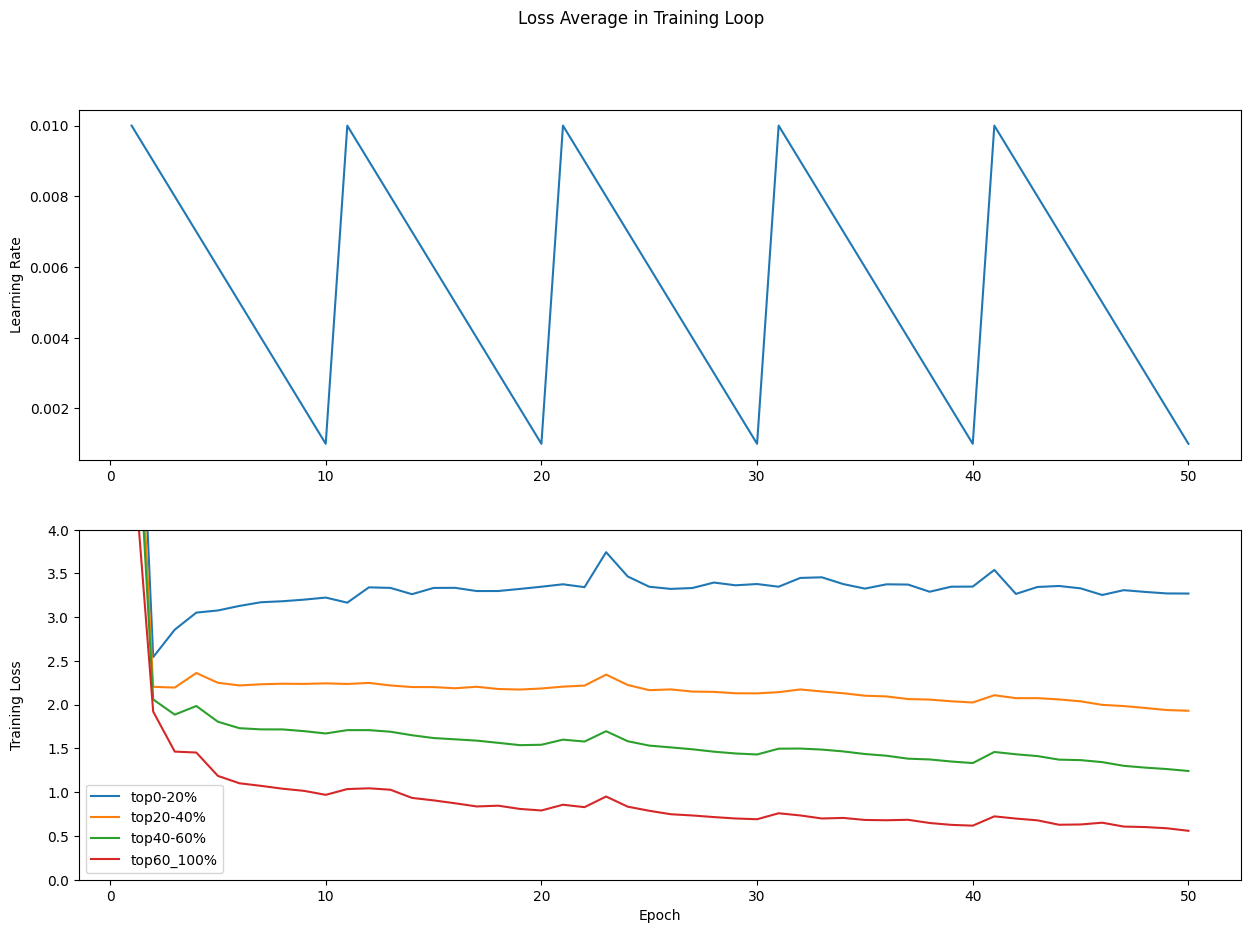

In [37]:
plot_loss_graph(loss_stage2,sorted_ind,r1=0.01,r2=0.001,c=10)

In [33]:
noise_accuracy(sorted_ind,noise_or_not,forget_rate=0.1)

noise_accuracy at top 0.1 is  0.8344


0.8344